# Portfolio Optimization: Factor Model
[![portfolio_factor_model.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/glebbelov/portfolio/portfolio_factor_model.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/glebbelov/portfolio/portfolio_factor_model.ipynb) [![Open In Deepnote](https://deepnote.com/buttons/launch-in-deepnote-small.svg)](https://deepnote.com/launch?url=https://github.com/ampl/colab.ampl.com/blob/master/authors/glebbelov/portfolio/portfolio_factor_model.ipynb) [![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/glebbelov/portfolio/portfolio_factor_model.ipynb) [![Open In Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/glebbelov/portfolio/portfolio_factor_model.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/glebbelov/portfolio/portfolio_factor_model.ipynb) [![Powered by AMPL](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/glebbelov/portfolio/portfolio_factor_model.ipynb)](https://ampl.com)

Description: Mean-Variance Portfolio Optimization model where the risk estimator is not given explicitly but is instead represented by a factor model, as is common in US equity models [1]. The original notebook is [3].

Tags: finance, portfolio optimization, mean variance, factor model, AMPL conditonal instantiation, cardinality constraint

Notebook author: Gleb Belov <<gleb@ampl.com>>

References:

[1] Menchero, J., Orr, D., Wang, J.: The Barra US equity model (USE4), methodology notes. English,
MSCI. May 2011.

[2] Gérard Cornuéjols, Javier Peña, and Reha Tütüncü. Optimization Methods in Finance. Cambridge University Press, 2 edition, 2018. doi:10.1017/9781107297340.

[3] Gurobi. Factor Model as Objective. https://gurobi-finance.readthedocs.io/en/latest/modeling_notebooks/factor_models_objective.html, accessed Nov 3, 2025.

[4] Mosek ApS. Ferrari, factorizing, and portfolios in conic form. https://themosekblog.blogspot.com/2024/03/ferrari-factorizing-and-portfolios-in.html, accessed Nov 4, 2025.

In [1]:
# Install dependencies
%pip install -q amplpy pandas numpy matplotlib

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gurobi", "mosek", "highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

In [3]:
# Import extras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Background

The *standard mean-variance (Markowitz) portfolio selection model* determines optimal investments that balance risk and expected return. In this notebook, we maximize *utility*, which is defined as a weighted linear function of return and risk that can be adjusted by varying the risk-aversion coefficient $\gamma$.

The standard formulation of this problem on $n$ assets reads

\begin{alignat*}{2}
\tag{1}
\max_{x \in \mathbf{R}^{n}} \quad        & \mu^\top x - \tfrac12 \gamma\ x^\top\Sigma x \\
\mbox{s.t.} \quad & 1_n^\top x = 1 \\
& 0 \le x \le 1\\
\end{alignat*}

where $\mu \in \mathbf{R}^n$ is the return estimator, $\Sigma \in \mathbf{R}^{n,n}$ is used as an estimator for the variance, and $1_n$ is the vector of $n$ ones. While it is certainly possible that the matrix $\Sigma$ is given explicitly (e.g., as the covariance matrix of a time series), it is often expressed implicitly through a *factor model*.  In that case, the matrix $\Sigma$ takes the form

$$
\Sigma = X \Sigma_0 X^T + D
$$

where

- $X \in \mathbf{R}^{n,k}$ is the factor exposure matrix,
- $\Sigma_0 \in \mathbf{R}^{k,k}$ is the symmetric positive definite (SPD) factor covariance matrix, and
- $D \in \mathbf{R}^{n,n}$ is the *diagonal* matrix of specific risks with $d_{ii} > 0$ for all $i$.

Effectively, this splits the risk into two sources:  One that arises from common risk factors (macroeconomic conditions, market trends, etc.) and a specific risk that is uncorrelated among the assets.  The number of factors, $k$, is typically much smaller than the number $n$ of assets.

The important observation from a computational point of view is the following: The factor model data is of size $nk + n$ (with $k \ll n$), while the covariance matrix $\Sigma$ is on the order of $n^2$. As we will see, optimization models using the factor model admit a smaller representation and typically offer improved computational performance.

## A synthetic factor model

Leading industry factor models are commercial products that are not necessary for our demonstration purposes. We are more interested in a qualitative comparison of solver performance using *some* factor model than in the actual economic meaning.  For this reason, our first step will be to create a simple, synthetic multivariate factor model that we can use in the study that follows.

The following function uses an uncorrelated factor covariance matrix $\Sigma_0$ that is used for sampling a multivariate normal distribution on `num_factors` factors along `time_steps` sampling points for `num_assets` assets:

In [4]:
def factor_model(num_assets, num_factors, timesteps):
    # Generate random factor model, risk is X * sigma0 * X.T + cov(u)
    sigma0 = np.diag(1 + np.arange(num_factors) + np.random.rand(num_factors))
    X = np.random.normal(size=(num_assets, num_factors))
    alpha = np.random.normal(loc=1, size=(num_assets, 1))
    u = np.random.multivariate_normal(
        np.zeros(num_assets), np.eye(num_assets), timesteps
    ).T
    d = np.diag(np.cov(u))  # NOTE: This is the _diagonal_ of D!

    # Time series in factor space
    TS_factor = np.random.multivariate_normal(
        np.zeros(num_factors), sigma0, timesteps
    ).T

    # Estimate mu from time series in full space
    mu = np.mean(alpha + X @ TS_factor + u, axis=1)

    return X, sigma0, d, mu

We skip the details of this statistical procedure for constructing $X$, $\Sigma_0$, $D$, and $\mu$; more background and details can be found in [2, Sect. 6.6].  The essential point is that we now have a synthetic factor model that acts similarly to a commercial factor model regarding solver performance.

## Taking advantage of the factor model structure

Ignoring the constant factor $\frac{1}{2}\gamma$ for a moment, the objective function we want to maximize includes

$$
x^T \Sigma x = x^T (X \Sigma_0 X + D) x = x^T X \Sigma_0 X^T x + x^T D x
$$

The first term, $x^T X \Sigma_0 X^T x$, would result in a quadratic function having $(n+1)\frac n2$ terms.  Since $\Sigma_0$ is SPD, it admits a *Cholesky factorization* $\Sigma_0 = LL^T$ where $L \in \mathbf{R}^{k,k}$ is a triangular matrix.  This allows us to rewrite the first term as

$$
x^T X \Sigma_0 X^T x = x^T \underbrace{X L}_{B} \underbrace{L^T X^T}_{B^T} x = \underbrace{x^T B}_{y^T} \underbrace{B^T x}_{y} = y^T y
$$

where we have substituted $y = B^T x$ in the last step. Also, note that $B = X L \in \mathbf{R}^{n, k}$ comprises only $nk$ elements.

The second term, $x^T D x$, comprises only $n$ terms (i.e., $\sum_i d_{ii} x_{i}^2$) and can be used as is.  Putting this together, the standard optimization model (1) can be rewritten as

\begin{alignat}{2}
\tag{2}
\max_{x \in \mathbf{R}^{n}, y \in \mathbf{R}^k} \quad        & \mu^\top x - \tfrac12 \gamma\ y^T y + \tfrac12 \gamma\ \sum_{i=1}^n d_{ii} x_i^2\\
\mbox{s.t.} \quad & 1_n^\top x = 1 \\
& y = B^T x.\\
& 0 \le x \le 1
\end{alignat}

Note that the $k$ variables $y$ do not have bound constraints.  Model (2) contains the much smaller matrix $B$ instead of $\Sigma$ in model (1), at the expense of $k$ additional optimization variables.  Generally, form (2) is advantageous for solver performance; we shall compare both in the next step.

## Comparing the two optimization models

In order to compare the solution times for models (1) and (2) above, we will define an AMPL model translating into either (1) or (2) depending on parameter `want_factor_model`.

## Use `%%writefile` to save AMPL model (see [AMPLPY Best Practices](https://dev.ampl.com/ampl/best-practices/amplpy-best-practices.html#))

In [5]:
%%writefile portfolio_sigma_factors.mod
set ASSETS;
set FACTORS default {};

# Parameters
param want_factor_model default 1;     # Model (1) or (2)
param expected_return {ASSETS};
param risk_free_rate;                  # gamma
# The below parameters are needed depending on want_factor_model
param factor_loadings {ASSETS, FACTORS};
param asset_specific_risks {ASSETS};
param asset_cov {ASSETS, ASSETS};   # The full matrix

# Variables
var weight {ASSETS} >=0 <=1;           # Asset weights
var portfolio_return = sum {i in ASSETS} weight[i] * expected_return[i];
# factor_exposure should be non-defined variables.
# Only instantiate if want_factor_model!=0
var factor_exposure {FACTORS: want_factor_model};
var portfolio_variance =
    if want_factor_model
        then
            sum {f in FACTORS} factor_exposure[f]^2
            + sum {a in ASSETS} asset_specific_risks[a] * weight[a]^2
    else
        sum {a1 in ASSETS, a2 in ASSETS}
            asset_cov[a1, a2] * weight[a1] * weight[a2];

# Objective: Minimize utility: expected return + portfolio variance
maximize Utility:
    portfolio_return - risk_free_rate / 2.0 * portfolio_variance;

# Constraints
subject to BudgetConstraint: 
    sum{i in ASSETS} weight[i] == 1;

# This definition constraint only instantiates
# if want_factor_model!=0
subject to FactorExposureDefinition{f in FACTORS: want_factor_model}:
    factor_exposure[f] == sum{i in ASSETS} weight[i] * factor_loadings[i, f];

Overwriting portfolio_sigma_factors.mod


Now we define two auxiliary functions to build an optimization model in either form using [AMPLPY](https://amplpy.readthedocs.io/).  Let's start with a function for the traditional form (1):

In [6]:
def build_sigma_model(gamma, sigma, mu):
    ampl.reset()
    ampl.read("portfolio_sigma_factors.mod")
    ampl.param["want_factor_model"] = 0
    ampl.set["ASSETS"] = range(1, mu.shape[0]+1)
    ampl.param["expected_return"] = mu
    ampl.param["factor_loadings"] = []
    ampl.param["asset_specific_risks"] = []
    ampl.param["asset_cov"] = sigma
    ampl.param["risk_free_rate"] = gamma

The second function builds the equivalent model (2):

In [7]:
def build_factor_model(gamma, B, d, mu):
    ampl.reset()
    ampl.read("portfolio_sigma_factors.mod")
    ampl.param["want_factor_model"] = 1
    ampl.set["ASSETS"] = range(1, mu.shape[0]+1)
    ampl.set["FACTORS"] = range(1, B.shape[1]+1)
    ampl.param["expected_return"] = mu
    ampl.param["factor_loadings"] = B
    ampl.param["asset_specific_risks"] = d
    ampl.param["asset_cov"] = []
    ampl.param["risk_free_rate"] = gamma

We are now ready to run a small benchmark.  We will keep a fixed risk aversion coefficient $\gamma$, and solve both models over a range of data with an increasing number of assets:

In [8]:
def RunBenchmark(ampl_options = {"solver": "gurobi", "gurobi_options": {"numericfocus": 3}}):
    np.random.seed(0xACAC)  # Fix seed for reproducibility

    num_factors = 72  # USE4 has 72 factors, too (see [1])
    timesteps = 700
    gamma = 0.025

    problem_dims = np.linspace(100, 750, 16, endpoint=True, dtype=int)
    time_sigma = []
    time_factor = []

    if "mp_options" not in ampl_options:
        ampl_options["mp_options"] = {}
    ampl_options["mp_options"]["tech:timing"] = 2   # For Initial.time_solver
    ampl.option = ampl_options

    for num_assets in problem_dims:
        X, sigma0, d, mu = factor_model(num_assets, num_factors, timesteps)

        print("Running with", num_assets, "of", problem_dims[-1], "assets: sigma...")
        sigma = X @ sigma0 @ X.T + np.diag(d)
        build_sigma_model(gamma, sigma, mu)
        ampl.snapshot("portfolio_sigma.run")
        ampl.solve()
        time_sigma.append(ampl.get_value("Initial.time_solver"))

        print("Running with", num_assets, "of", problem_dims[-1], "assets: factor model...")
        L = np.linalg.cholesky(sigma0)
        B = X @ L
        build_factor_model(gamma, B, d, mu)
        ampl.snapshot("portfolio_factors.run")
        ampl.solve()
        time_factor.append(ampl.get_value("Initial.time_solver"))

        print("   ...done  ---------------------------------------")

    return problem_dims, time_sigma, time_factor

### Graphical output code

In [9]:
def Plot(problem_dims, time_sigma, time_factor, caption):
    fig, ax = plt.subplots()
    ax.plot(problem_dims, time_sigma, c="blue", marker="o", label="sigma")
    ax.plot(problem_dims, time_factor, c="red", marker="o", label="factor")
    ax.legend()
    plt.title(caption)
    plt.xlabel("No. assets")
    plt.ylabel("Solution time (sec.)")
    plt.grid(True)
    plt.close(fig)

    return fig

### Runner wrapper

In [10]:
def BenchmarkSolver(solver, options={"gurobi_options": {"outlev": 0, "timing": 2}}):
    options["solver"] = solver
    p_dims, time_sigma, time_factor = RunBenchmark(options)
    fig = Plot(p_dims, time_sigma, time_factor, solver.capitalize() + " benchmark")

    return fig

### Run with different solvers

In [11]:
fig = BenchmarkSolver("gurobi")

Running with 100 of 750 assets: sigma...
Gurobi 13.0.0:   tech:timing = 2
  tech:outlev = 0
  tech:timing = 2


/Users/gb5/Documents/prj/AMPL/escrow/cmake/acl/massage.h:98:34: runtime error: signed integer overflow: 33 * 489929840339196788 cannot be represented in type 'long'
SUMMARY: UndefinedBehaviorSanitizer: undefined-behavior /Users/gb5/Documents/prj/AMPL/escrow/cmake/acl/massage.h:98:34 
/Users/gb5/Documents/prj/AMPL/escrow/cmake/acl/massage.h:98:37: runtime error: signed integer overflow: 7842240797665118548 + 6386558351771823828 cannot be represented in type 'long'
SUMMARY: UndefinedBehaviorSanitizer: undefined-behavior /Users/gb5/Documents/prj/AMPL/escrow/cmake/acl/massage.h:98:37 
/Users/gb5/Documents/prj/AMPL/escrow/cmake/acl/massage.h:98:34: runtime error: signed integer overflow: 33 * 556558325256565636 cannot be represented in type 'long'
SUMMARY: UndefinedBehaviorSanitizer: undefined-behavior /Users/gb5/Documents/prj/AMPL/escrow/cmake/acl/massage.h:98:34 
/Users/gb5/Documents/prj/AMPL/escrow/cmake/acl/collect.c:1424:9: runtime error: applying non-zero offset 8 to null pointer
SUMM

NL model read time = 0.022245s
NL model conversion time = 0.045357s

Gurobi 13.0.0: optimal solution; objective 2.889499366
0 simplex iterations
11 barrier iterations
Setup time = 0.081387s
Solver time = 0.007210s
Output time = 0.000009s
Total time = 0.088606s

suffix time OUT;
suffix time_read OUT;
suffix time_setup OUT;
suffix time_output OUT;
suffix time_solver OUT;
suffix time_conversion OUT;
Running with 100 of 750 assets: factor model...
Gurobi 13.0.0:   tech:timing = 2
  tech:outlev = 0
  tech:timing = 2
NL model read time = 0.006218s
NL model conversion time = 0.008540s

Gurobi 13.0.0: optimal solution; objective 2.889499372
0 simplex iterations
14 barrier iterations
Setup time = 0.016534s
Solver time = 0.004845s
Output time = 0.000010s
Total time = 0.021390s

suffix time OUT;
suffix time_read OUT;
suffix time_setup OUT;
suffix time_output OUT;
suffix time_solver OUT;
suffix time_conversion OUT;
   ...done  ---------------------------------------
Running with 143 of 750 assets:

/Users/gb5/Documents/prj/AMPL/escrow/cmake/acl/func.c:1375:14: runtime error: member access within null pointer of type 'Library'
SUMMARY: UndefinedBehaviorSanitizer: undefined-behavior /Users/gb5/Documents/prj/AMPL/escrow/cmake/acl/func.c:1375:14 


  tech:timing = 2
  tech:outlev = 0
  tech:timing = 2
NL model read time = 0.014339s
NL model conversion time = 0.082731s

Gurobi 13.0.0: optimal solution; objective 3.050585815
0 simplex iterations
12 barrier iterations
Setup time = 0.098607s
Solver time = 0.012008s
Output time = 0.000016s
Total time = 0.110631s

suffix time OUT;
suffix time_read OUT;
suffix time_setup OUT;
suffix time_output OUT;
suffix time_solver OUT;
suffix time_conversion OUT;
Running with 143 of 750 assets: factor model...
Gurobi 13.0.0:   tech:timing = 2
  tech:outlev = 0
  tech:timing = 2
NL model read time = 0.006343s
NL model conversion time = 0.011266s

Gurobi 13.0.0: optimal solution; objective 3.050585815
0 simplex iterations
15 barrier iterations
Setup time = 0.019190s
Solver time = 0.006760s
Output time = 0.000010s
Total time = 0.025960s

suffix time OUT;
suffix time_read OUT;
suffix time_setup OUT;
suffix time_output OUT;
suffix time_solver OUT;
suffix time_conversion OUT;
   ...done  -----------------

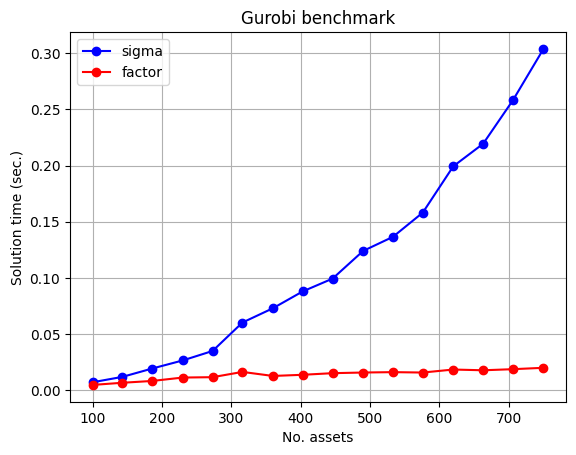

In [12]:
fig

In [13]:
fig = BenchmarkSolver("mosek")

Running with 100 of 750 assets: sigma...
MOSEK 11.0.29:   tech:timing = 2
NL model read time = 0.003649s
NL model conversion time = 0.002614s

MOSEK 11.0.29: optimal, termination reason unknown; objective 2.889499379
0 simplex iterations
11 barrier iterations
Setup time = 0.010774s
Solver time = 0.008641s
Output time = 0.000004s
Total time = 0.019419s

suffix time OUT;
suffix time_read OUT;
suffix time_setup OUT;
suffix time_output OUT;
suffix time_solver OUT;
suffix time_conversion OUT;
Running with 100 of 750 assets: factor model...
MOSEK 11.0.29:   tech:timing = 2
NL model read time = 0.000780s
NL model conversion time = 0.000380s

MOSEK 11.0.29: optimal, termination reason unknown; objective 2.889499604
0 simplex iterations
10 barrier iterations
Setup time = 0.001513s
Solver time = 0.005062s
Output time = 0.000008s
Total time = 0.006583s

suffix time OUT;
suffix time_read OUT;
suffix time_setup OUT;
suffix time_output OUT;
suffix time_solver OUT;
suffix time_conversion OUT;
   ...d

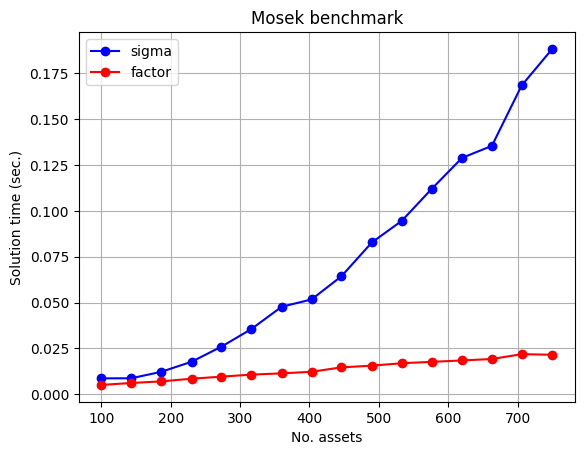

In [14]:
fig

In [15]:
fig = BenchmarkSolver("highs", {"highs_options": "tech:threads=8"})

Running with 100 of 750 assets: sigma...
HiGHS 1.11.0:   tech:timing = 2
  tech:threads = 8
NL model read time = 0.002179s
NL model conversion time = 0.002870s

HiGHS 1.11.0: optimal solution; objective 2.889499379
0 simplex iterations
0 barrier iterations
Setup time = 0.010177s
Solver time = 0.002539s
Output time = 0.000006s
Total time = 0.012722s

suffix time OUT;
suffix time_read OUT;
suffix time_setup OUT;
suffix time_output OUT;
suffix time_solver OUT;
suffix time_conversion OUT;
Running with 100 of 750 assets: factor model...
HiGHS 1.11.0:   tech:timing = 2
  tech:threads = 8
NL model read time = 0.000258s
NL model conversion time = 0.000458s

HiGHS 1.11.0: optimal solution; objective 2.889499379
0 simplex iterations
0 barrier iterations
Setup time = 0.001204s
Solver time = 0.004149s
Output time = 0.000004s
Total time = 0.005357s

suffix time OUT;
suffix time_read OUT;
suffix time_setup OUT;
suffix time_output OUT;
suffix time_solver OUT;
suffix time_conversion OUT;
   ...done  -

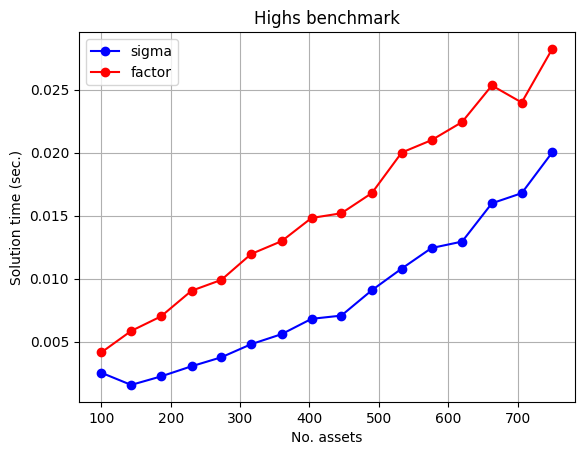

In [16]:
fig

For Gurobi and Mosek, it is clear that the solve times of (2) are much smaller both in absolute and asymptotic terms.  The data may appear somewhat nonsmooth over the problem dimensions.  These are artifacts from multi-threading and different code paths in the computational kernels used for dense matrix multiplication. However HiGHS runs about 10x faster overall and the sigma model works better, which might be due to HiGHS presolve.

However, HiGHS cannot currently solve MIQP which would arise when adding discrete entities to the model, for example, a cardinality constraint (see the [MP Modeling Guide](https://mp.ampl.com/model-guide.html)):

In [17]:
n_positive = ampl.get_value("count {a in ASSETS} (weight[a] > 1e-4)")
n_pos_new = round(0.7 * n_positive)
print("Constrain to", n_pos_new, "assets from currently", n_positive)
ampl.eval("s.t. Cardinality: atmost {} {{a in ASSETS}} (weight[a] > 0);".
          format(n_pos_new))
ampl.solve(solver="gurobi", gurobi_options="outlev=1", verbose=True)

print()
print("New number of positive assets:",
      ampl.get_value("count {a in ASSETS} (weight[a] > 1e-4)"))

Constrain to 30 assets from currently 43
Gurobi 13.0.0:   tech:timing = 2
  tech:outlev = 1
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2719854
Gurobi 13.0.0beta1 - expires 2025-12-02
WLS license 2719854 - registered to AMPL Optimization
NL model read time = 0.023518s

AMPL MP initial flat model has 822 variables (0 integer, 0 binary);
Objectives: 1 quadratic; 
Constraints:  74 linear;
Algebraic expressions:  1 count;
Logical expressions:  750 conditional (in)equalitie(s); 750 not;

AMPL MP final model has 2324 variables (2 integer, 1500 binary);
Objectives: 1 quadratic; 
Constraints:  825 linear;
Logical expressions:  750 indeq;


NL model conversion time = 0.079990s

Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0beta1 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
InfUnbdInfo  1

WLS license 271985

## Takeaways

- Incorporating explicit factors to model risk in an AMPL model is straightforward.
- AMPL allows easy switching between state-of-the-art solvers.
- Using factor risk models instead of the derived full covariance matrix can greatly improve solution time.